In [1]:
!nvidia-smi

Mon Sep  9 14:44:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P3             15W /   40W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import jaccard_score

In [3]:
# Custom dataset class for loading images and masks with specific file naming convention
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Only keep the images that end with '_img.png'
        self.images = [img for img in os.listdir(image_dir) if img.endswith('_img.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image file path
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        # Derive the corresponding mask file path by replacing '_img.png' with '_mask.png'
        mask_filename = img_filename.replace('_img.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_filename)

        # Load the image and the mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale mask for binary segmentation

        # Apply the same transformations to both image and mask (if any)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Convert mask to the correct format (removing channel dimension)
        mask = torch.squeeze(mask, dim=0)  # From [1, H, W] to [H, W]

        return image, mask

# Dataset transformation (resizing and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
# Function to calculate Intersection over Union (IoU) for binary masks
def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()  # Apply threshold to convert to binary mask
    pred_np = pred.cpu().numpy().flatten()
    target_np = target.cpu().numpy().flatten()
    
    # Calculate IoU
    iou = jaccard_score(target_np, pred_np, average='binary')
    return iou

# Train function
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Validation function with IoU calculation (mAP equivalent)
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    iou_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
    
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            running_loss += loss.item()
    
            preds = torch.argmax(outputs, dim=1)
            
            # Compute IoU for each batch and append to list
            iou = calculate_iou(preds, masks)
            iou_scores.append(iou)

    mean_iou = np.mean(iou_scores)
    return running_loss / len(dataloader), mean_iou


In [15]:
# Paths to your dataset
image_dir = "SegData/Images"
mask_dir = "SegData/Masks"

# Load dataset
dataset = CustomSegmentationDataset(image_dir, mask_dir, transform)

# Split dataset into train and val (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Load train and validation data
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load FCN model with pre-trained weights, and modify for binary segmentation
model = models.segmentation.fcn_resnet50(pretrained=True)
num_classes = 2  # Binary segmentation (1 foreground + 1 background)
model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Load the trained model weights
#model.load_state_dict(torch.load('best_model_fcn.pth'))
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [9]:
# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in FCN-ResNet50: {num_params}")

Total number of parameters in FCN-ResNet50: 35307588


In [11]:

best_iou = 0.0  # Initial best IoU
best_model_path = "best_model_fcn.pth"  # Path to save the best model

num_epochs = 40
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, mean_iou = validate(model, val_loader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, mAP (IoU): {mean_iou:.4f}")

    # Check if the current IoU is better than the best IoU seen so far
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), best_model_path)  # Save the model's state
        print(f"New best IoU: {best_iou:.4f}. Model saved to {best_model_path}")

print(f"Training complete. Best IoU: {best_iou:.4f}.")

Epoch [1/40]
Train Loss: 0.1551
Val Loss: 0.1692, mAP (IoU): 0.3806
New best IoU: 0.3806. Model saved to best_model_fcn.pth
Epoch [2/40]
Train Loss: 0.1338
Val Loss: 0.1338, mAP (IoU): 0.4882
New best IoU: 0.4882. Model saved to best_model_fcn.pth
Epoch [3/40]
Train Loss: 0.1243
Val Loss: 0.1158, mAP (IoU): 0.5219
New best IoU: 0.5219. Model saved to best_model_fcn.pth
Epoch [4/40]
Train Loss: 0.1129
Val Loss: 0.1531, mAP (IoU): 0.4155
Epoch [5/40]
Train Loss: 0.1128
Val Loss: 0.1069, mAP (IoU): 0.5245
New best IoU: 0.5245. Model saved to best_model_fcn.pth
Epoch [6/40]
Train Loss: 0.1058
Val Loss: 0.1030, mAP (IoU): 0.5826
New best IoU: 0.5826. Model saved to best_model_fcn.pth
Epoch [7/40]
Train Loss: 0.1020
Val Loss: 0.1031, mAP (IoU): 0.5848
New best IoU: 0.5848. Model saved to best_model_fcn.pth
Epoch [8/40]
Train Loss: 0.0932
Val Loss: 0.1106, mAP (IoU): 0.5777
Epoch [9/40]
Train Loss: 0.0951
Val Loss: 0.1008, mAP (IoU): 0.6112
New best IoU: 0.6112. Model saved to best_model_fcn.

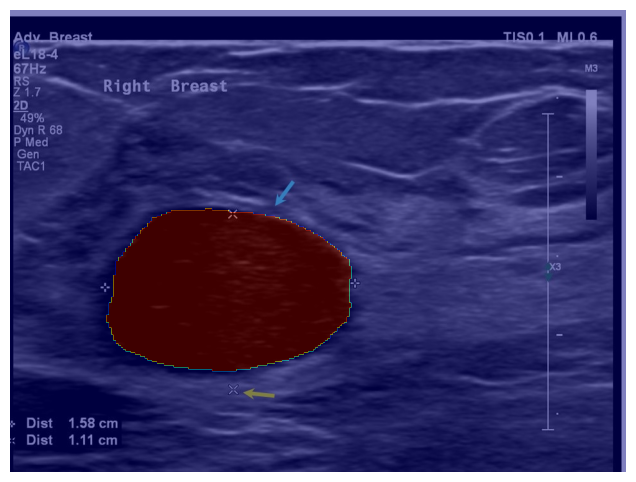

In [24]:
model.load_state_dict(torch.load('best_model_fcn.pth'))  # Load your trained model weights
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and preprocess the image
img_path = "test/parallel03a.jpg"
img = Image.open(img_path).convert("RGB")

# Save the original size for plotting purposes
original_size = img.size

img_transformed = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(img_transformed)['out']  # Get the output from the model

# Get the predicted class for each pixel
pred = torch.argmax(output, dim=1)  # Shape: [batch_size, height, width]
pred = pred.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU

# Convert the prediction to binary format
# Assuming binary segmentation: 0 is background, 1 is foreground
mask_binary = (pred > 0).astype(np.uint8)  # Convert to binary mask

# Resize the mask to match the original image size
mask_binary_resized = np.array(Image.fromarray(mask_binary).resize(original_size, Image.NEAREST))

# Plot the original image and overlay the mask
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Display the original image
ax.imshow(img)

# Overlay the mask with some transparency
ax.imshow(mask_binary_resized, cmap='jet', alpha=0.5)  # Use alpha for transparency

ax.axis('off')  # Turn off axis labels
plt.show()